## ThoughtCloud: A script to generate Lyric word clouds of your favourite artist
This project is a novel but simple idea that combines nlp with two of my favourite things, music and graphics. With this code one can visualize what their favourite artist's art is based upon. This code extracts data from the web with the help of a web scraping scipt(which took me a very long time to perfect), and then applies NLP techniques (ntlk toolkit) to process the raw data and then a data visualisation tool (wordcloud) to generate some awesome graphics!<br>
<i> I have tried my best to document each line of my code. Please free feel to contact me for more insight into any of the aspects.</i>

### Part 1: Importing all the required libraries that are to be used throughout the code

In [1]:
import matplotlib.pyplot as plt #---------------for ploting the wordcloud in the notebook
import nltk #-----------------------------------for processing text 
import numpy as np #----------------------------basic python library
import pandas as pd #---------------------------for accessing the dataframe of lyrics
import re #-------------------------------------regrex library for cleaing and processing text
import random #---------------------------------to choose a random image mask

import os #-------------------------------------to access files from the computer
from os import path #---------------------------to access files through path
from PIL import Image #-------------------------used here for generating mask for wordcloud

from nltk.stem import WordNetLemmatizer #-------to lemmatize the raw data
from wordcloud import WordCloud, ImageColorGenerator #--and finally to generate the wordcloud

### Part 2: Getting the user's favourite artist's name

In [2]:
artist=input("Enter your favourite artist: ")

Enter your favourite artist: cold play


### Part 3: Generating the URL to scrap lyrics to top 100 songs by the selected artist

I have used www.songlyrics.com since they allow scraping without any interuption.<br> 
songlyrics.com follow this url format for every artist : http://www.songlyrics.com/artistname-lyrics/ <br>
(SideNote: I also got blocked out of www.azlyrics.com for scraping data without permission, it was really hard to find a site that allowed a crawler to access their data, took me a lot of time)

In [3]:
#generate the url
if len(artist.split())<2:  #----------if artist name is a single term
   
    url="http://www.songlyrics.com/"+artist.lower()+"-lyrics/"
    
else: #-------------------------------if artist name has spaces between them
    url="http://www.songlyrics.com/"+artist.lower().replace(" ","-")     
    url=url+"-lyrics/"
    

### Part 4: Writing script to scrap lyrics(raw data) from the url

This required the use of <i>NLP Assignment: 4</i>.<br>
The script below creates a dataframe with the lyrics from top 100 songs by the artist.<br>
The main task here involved identifying which html tags contain the required data (song name, links to the song lyrics, the genre of the artist)<br>
This website had the tracklist in the form of an html table, with each table containing song name, song id and link (href) to the song.<br>
The site has a lot of bad html therefore, to ensure that the links point to actual songs I have used regular expressions. And the site also has links to several versions of the same song (though same lyrics), the script also takes care of that with a simple if statement(simple but very useful for diversity in lyrics).<br>
All these things required hours of debugging and trying numerous artists one by one.


In [5]:
#web scraping raw data

#importing local libraries for accessing raw data from the web
import requests #----------------------------------required for making GET requests to the web server
from bs4 import BeautifulSoup #--------------------to grab and process the html
import time #--------------------------------------required to slow down the number of requests made to the server

try:
    result=requests.get(url) #---------------------get data from the artist's url

except:
    print("Url cannot be accessed") #--------------in case the request above fails

soup = BeautifulSoup(result.text, "html.parser")#--parse the html from the requested data

song_names=[] #------------------------------------list to contain the song names
lyrics=[] #----------------------------------------list to contain all the lyrics 
 
table=soup.find('table',{'class':'tracklist'}) #---find the "table" tag from the html. This table tag cotains the tracklist 

genre=soup.find('div',{'class':'pagetitle'}) #-----find the artist's genre
genre=genre.find('a').text #-----------------------extract the genre from the html
genre=genre.lower() #------------------------------format the genre

print("processing...")

#regular expressions for formatting song names (this formatting helps to identify repetition of songs)

regex1=re.compile("(.*?)\s*\(") #------------------to ignore any brackets in the song name ex: Olivia (Remix verion)=> Olivia
regex2=re.compile("(.*?)\s-\s(.*?)") #-------------to remove any '-' in the song name ex: Olivia-Remix => Olivia
regex3=re.compile("(^[a-zA-Z0-9$@$!%*?&#^-_. +]+$)") #--to check if the song name is valid, i.e. contains only ASCII characters

# create tracklist
i=1 #--------------------------------------------iterator to check if 100 unique songs have already been parsed
for row in table.find_all('tr'): #---------------for each "table row" tag in the "table" of songs
    
    col=row.find_all('td') #---------------------find all "table columns" containing data
    s=col[1].text.lower() #----------------------col[0] is song number and col[1] is song name
        
    try:
        m=regex1.match(s) #---------------------check if there are any brackets in song name s
        s=m.group(1) #--------------------------output the content before the brackets, ignoring any content thereafter

    except:
        pass #----------------------------------if regex matching fails, i.e. no brackets found, do nothing
    
    try:
        m=regex2.match(s) #---------------------check if theres a "-" in the song name
        s=m.group(1) #--------------------------extract content before the "-", ignoring anything after that
        
    except:
        pass #----------------------------------if no "-" found, do nothing
    
    try:
        m=regex3.match(s) #---------------------check if the song name contains ASCII characters
        s=m.group(1) #--------------------------extract ASCII part of the name, ignore rest
        
    except:
        continue #------------------------------if not ASCII, i.e. matching fails then go to start of loop and get next song
    
    if s not in song_names: #-------------------check if song is already in the list of songs already extracted
        song_names.append(s) #------------------append to the list if a new song is found

        if col[1].a is None: #------------------check if link to lyrics exist, if not then move to next song
            pass

        else:
            lyrics_url=col[1].a.attrs['href'] #--extract url to lyrics from the <a> html tag
            result=requests.get(lyrics_url) #----get data from the lyrics_url
            lyric_soup=BeautifulSoup(result.text,'html.parser') #------------Parse html from requsted data
            lyrics.append(lyric_soup.find('p',{'id':"songLyricsDiv"}).text) #--extract song lyrics from the <p> tag in the extracted html

        i=i+1 #----------------------------------increase iterator by 1, i.e. 1 new song added to the list
        #print("song number= ",i) 
        if i>100: #-------------------------------if 100 songs already extracted, then break out of loop
            break
    
    else:
        continue
        
    
    time.sleep(0.5) #----------------------------add time delay between two requests to avoid appearing as a DOS attack


df=pd.DataFrame({'Song': song_names, 'Lyrics':lyrics}) #---add the extracted content to a dataframe
print('Dataframe generated!')

df.head() #---------------------------------------view first 5 entries of df (just to be sure)

processing...
Dataframe generated!


,Song,Lyrics
0,clocks,Lights go out and I can't be saved\nTides that...
1,yellow,Look at the stars\nLook how they shine for you...
2,love,i knew it right from the start with you in my ...


### Part 5: Cleaning the raw data with nltk

The data extracted into the dataframe contains a lot of unnecessary characters and elemenst and is filled with remenants of html, so I needed to clean the data before any further use. This required the use of basic string operations of python and nltk tools.<br><br>
The following snippet reads all the lyrics from the dataframe into a string (all_lyrics) and it cleans the raw html, by removing newline ("\n") elements and unnecessary backslashes ("\\").

In [6]:
# cleaning raw text
all_lyrics="" #---------------------------------------------------------create empty list

for index,row in df.iterrows(): #---------------------------------------iterate through the dataframe
    lyrics=row['Lyrics'].lower().replace("\n"," ").replace("\"","") #---get lyrics from dataframe and remove unwanted chars
    all_lyrics=all_lyrics+lyrics #--------------------------------------add cleaned lyrics to the list

all_lyrics[:100] #------------------------------------------------------display first 100 elements of lyric list

"lights go out and i can't be saved tides that i tried to swim against you've put me down upon my kne"

The following snippet removes all the abbreviations (like "i'm","you're") and replaces them with the corresponding expansions.
Also any words with length less than 3 are removed from the string (which also means removing vocables like "oh", "na" "la" from the songs)

In [7]:
# cleaning the lyrics
clean_lyrics=all_lyrics.replace("'ll","").replace("gotta","got").replace("i'm","i am") #-------------------replace statement 1
clean_lyrics=clean_lyrics.replace("you're","you are").replace("can't","can not").replace("don't","do not")#-replace statement 2
clean_lyrics=clean_lyrics.replace("doesn't","does not").replace("'s"," is").replace("'ve"," have") #--------replace statement 3

clean_lyrics = ' '.join([w for w in clean_lyrics.split(' ') if len(w)>3]) #---------------remove lyrics with length less than 3
clean_lyrics[:100] #----------------------------------------------------------------------display first 100 cleaned lyrics

'lights saved tides that tried swim against have down upon knees beg, plead, singing come things unsa'

### Part 6: Tokenizing and Lemmatizing lyric data with nltk

To analyze the lyrics in a more truthful manner, the different morphological forms of a word must be eliminated. This will give an essence of what the artist writes about the most.<br><br>
The code below tokenizes the cleaned lyrics using nltk's word_tokenize function

In [8]:
#tokenize and inspect tokens
tokens=nltk.tokenize.word_tokenize(clean_lyrics) #------------------------tokenize the cleaned lyrics

The code below lemmatizes the tokens and removes any left tokens with word length less than 3

In [9]:
#lemmatize and inspect lemmatized tokens
wnl=WordNetLemmatizer() #----------------------------------------------------------create lemmatizer object
lemmatized_tokens=[wnl.lemmatize(word,'v') for word in tokens if len(word)>2] #----lemmatize the tokens

This snippet removes any stop words like "the","that","this" , and creates a counter object to maintain count of all lemmatized tokens. This counter object will be used to create the word cloud in the end.

In [10]:
#remove stopwords and inspect tokens
from collections import Counter #----------------------------------------local import to create a counter object
from nltk.corpus import stopwords #--------------------------------------local import to remove stopwords
stop_words = set(stopwords.words('english')) #---------------------------get unique stopwords of english
stop_words.update(["like", "away", "take", "know", "n't"]) #-------------some recurrent unnecessary words
filtered_tokens=[w for w in lemmatized_tokens if w not in stop_words] #--remove stop words and get filtered tokens

count=Counter(filtered_tokens) #-----------------------------------------create a counter with word frequencies 
count.most_common(20) #--------------------------------------------------display 20 most common tokens in the lyrics

[('home', 9),
 ('look', 9),
 ('shine', 8),
 ('yellow', 5),
 ('sing', 4),
 ('come', 4),
 ('want', 4),
 ('skin', 4),
 ('things', 3),
 ('nothing', 3),
 ('else', 3),
 ('compare', 3),
 ('yeah', 3),
 ('turn', 3),
 ('thing', 3),
 ('love', 3),
 ('swim', 2),
 ('upon', 2),
 ('stop', 2),
 ('part', 2)]

### Part 7: Creating a mask for the wordcloud

The following lines of code create an image mask for the final wordcloud. The code creates a mask according to the image path entered by the user. The word cloud will be in the shape of the image. If the image is not found, no mask is set to None, i.e. no mask will be applied.

In [19]:
#select wordcloud mask based on genre
dir_path=path.dirname(r"C:\Users\hp\Desktop\ThoughtCloud\shapes\"") #--------------------default repo path
image_name="rock.jpg"
mask_flag=1

try:
    mask=np.array(Image.open(path.join(dir_path,image_name))) #--------------try opening the image from the repo
except:
    print("Image cannot be opened, setting mask to default")
    mask_flag=0
    mask=None #--------------------------------------------------------------if image fails to open then use no mask


### Part 8: Creating the WORDCLOUD !

<i>The following snippet is where the magic actually happens.</i><br>
FOr this, I created a wordcloud object with the some relevant parameters, and then generated the word cloud from the counter object created after cleaning, tokenizing and lemmatizing and again cleaning the lyrics. The wordcloud is displayed using the matplotlib functions.

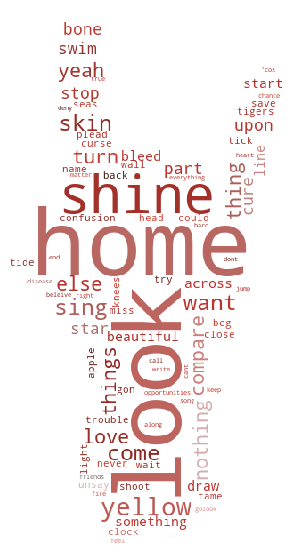

In [20]:
#create wordcloud

wc=WordCloud(background_color="white",max_words=10000,min_font_size=5,width=2000,height=2000,mask=mask) #---set parameters
wc.generate_from_frequencies(count) #------------------------------------generate word cloud from counter object

plt.figure(figsize=(20,10)) #--------------------------------------------fixing plot size for better view

if mask_flag: #----------------------------------------------------------if mask is applied
    image_colors=ImageColorGenerator(mask) #-----------------------------select the colors as in the mask
    plt.imshow(wc.recolor(color_func=image_colors)) #--------------------recolor the wordcloud according to the mask
else:
    plt.imshow(wc) #-----------------------------------------------------if mask is None, show default colored wordcloud

plt.axis("off") #--------------------------------------------------------disable axis
plt.show() #-------------------------------------------------------------show plot

Save the wordcloud of your favourite artist's lyrics to your system and then have it printed upon a T-shirt or a coffee mug!!

In [21]:
d_path=path.dirname(r"C:\Users\hp\Desktop\"") #----------------set path to save the image file
image_name=artist+".jpg" #-------------------------------------set name of the image
wc.to_file(path.join(d_path,image_name)) #---------------------save the figure as a jpg